<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/dynamiccompressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install git+https://github.com/equinor/neqsimpython.git

Relevant info:
[Intro to dynamic process simulations in neqsim](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/dynamicsimul.ipynb)

#Dynamic compressor calculations using NeqSim

In the following examples we look into how dynamic calculations in NeqSim can be used for compression processes. We will further demonstrate how to controll the process and how to implement an anti surge controll algorithm.



#Example 1: Process behavior when increasing speed of the compressor.
In this exampe we would expect that the flow through the compressor will increase, and that the pressure of the inlet separator will drop, whil the pressure of the outlet process will increase. THe pressure change will be dependent on the volume of gas upstream and downstream the compressor.

 speed  3000.0 feed flow  5000.000000000001  compressor flow rate  5000.000000000001  out flow  5000.000000000002  delta p  51.74353604996094  pres inn  50.0  pres out  101.74353604996094


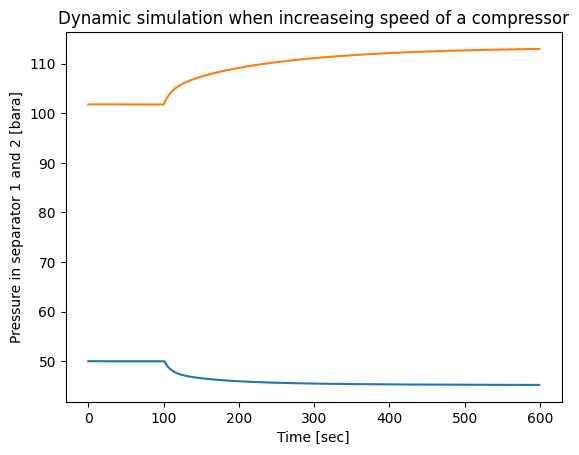

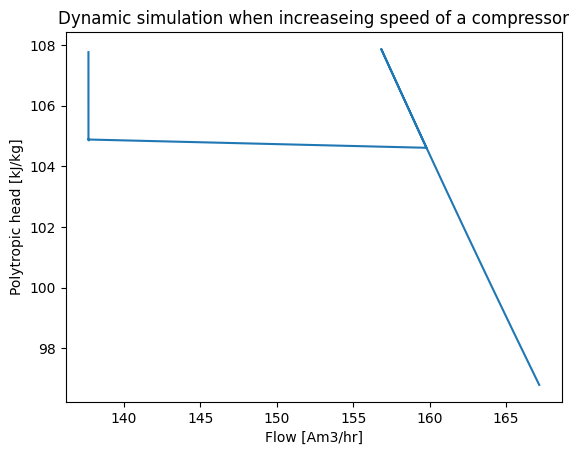

In [2]:
import neqsim
from neqsim import jNeqSim

import matplotlib.pyplot as plt

testSystem2 = jNeqSim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
testSystem2.addComponent("methane", 1.1);
testSystem2.addComponent("ethane", 0.1);
testSystem2.setMixingRule(2);

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream("Stream1", testSystem2);
stream1.setFlowRate(5000.0, "kg/hr");
stream1.setPressure(100.0, "bara");
stream1.setTemperature(55.0, "C");

valve1 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(50.0);
valve1.setPercentValveOpening(50);
valve1.setCalculateSteadyState(False);

separator1 = jNeqSim.processSimulation.processEquipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream());
separator1.setCalculateSteadyState(False);
separator1.setSeparatorLength(3.0);
separator1.setInternalDiameter(0.8);
separator1.setLiquidLevel(0.0);

compressor1 = jNeqSim.processSimulation.processEquipment.compressor.Compressor(separator1.getGasOutStream());
compressor1.setCalculateSteadyState(False);
compressor1.setOutletPressure(100.0);

separator2 = jNeqSim.processSimulation.processEquipment.separator.Separator("separator_2");
separator2.addStream(compressor1.getOutletStream());
separator2.setCalculateSteadyState(False);
separator2.setSeparatorLength(3.0);
separator2.setInternalDiameter(0.8);
separator2.setLiquidLevel(0.0);

valve2 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_2", separator2.getGasOutStream());
valve2.setOutletPressure(50.0);
valve2.setPercentValveOpening(50);
valve2.setCalculateSteadyState(False);

p = jNeqSim.processSimulation.processSystem.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(separator1);
p.add(compressor1);
p.add(separator2);
p.add(valve2);

p.run();
compchartgenerator = jNeqSim.processSimulation.processEquipment.compressor.CompressorChartGenerator(compressor1);
compressor1.setCompressorChart(compchartgenerator.generateCompressorChart("normal"));
compressor1.getCompressorChart().setUseCompressorChart(True);
p.run();

print(" speed ",compressor1.getSpeed(), "feed flow ", stream1.getFlowRate("kg/hr"), " compressor flow rate "
  ,compressor1.getInletStream().getFlowRate("kg/hr"), " out flow "
  , valve2.getOutletStream().getFlowRate("kg/hr"), " delta p "
  , (compressor1.getOutletStream().getPressure() - compressor1.getInletStream().getPressure())
  , " pres inn " , compressor1.getInletStream().getPressure() , " pres out "
  , compressor1.getOutletStream().getPressure());

time = []
pressuresep1 = []
pressuresep2= []
flow = []
head = []

p.setTimeStep(1.0);
for i in range(100):
  time.append(p.getTime())
  pressuresep1.append(separator1.getPressure())
  pressuresep2.append(separator2.getPressure())
  flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
  head.append(compressor1.getPolytropicFluidHead())
  p.runTransient();

#increaseing compressor speed
compressor1.setSpeed(compressor1.getSpeed()+200)
for i in range(500):
  time.append(p.getTime())
  pressuresep1.append(separator1.getPressure())
  pressuresep2.append(separator2.getPressure())
  flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
  head.append(compressor1.getPolytropicFluidHead())
  p.runTransient();

plt.plot(time, pressuresep1)
plt.plot(time, pressuresep2)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure in separator 1 and 2 [bara]")
plt.show()

plt.plot(flow, head)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Polytropic head [kJ/kg]")
plt.show()


Text(0, 0.5, 'Head [kJ/kg]')

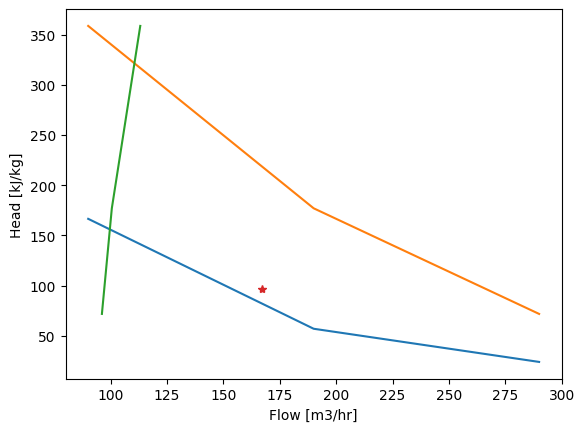

In [5]:
flow = []
head = []
head2 = []
surge =[]

for i in range(90,300,100):
    flow.append(i)
    head.append(compressor1.getCompressorChart().getPolytropicHead(i, 3000))
    head2.append(compressor1.getCompressorChart().getPolytropicHead(i, 4000))

for i in head:
  surge.append(compressor1.getCompressorChart().getSurgeCurve().getSurgeFlow(i))

plt.plot(flow, head)
plt.plot(flow, head2)
plt.plot(surge, head2)
plt.plot(compressor1.getInStream().getFlowRate('m3/hr'), compressor1.getPolytropicFluidHead(), marker='*')
plt.xlabel('Flow [m3/hr]')
plt.ylabel('Head [kJ/kg]')

#Example 2: Process behavior when adding compressor speed controll
In this exampe we will add a compressor speed controller for controlling pressure downstream the compressor. A PI regulator will be used for controlling the speed. We start with a process with 100 bara output pressure and increase the setpoint of the controller to 120 bara.

 speed  3000.0 feed flow  500.9999999999999  compressor flow rate  500.9999999999999  out flow  500.9999999999999  delta p  51.74353604996094  pres inn  50.0  pres out  101.74353604996094


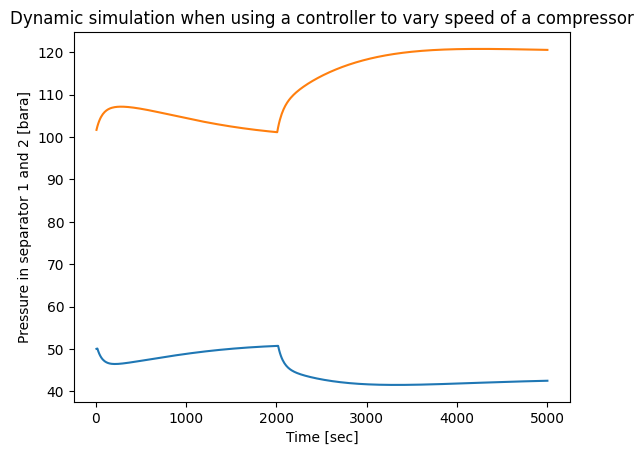

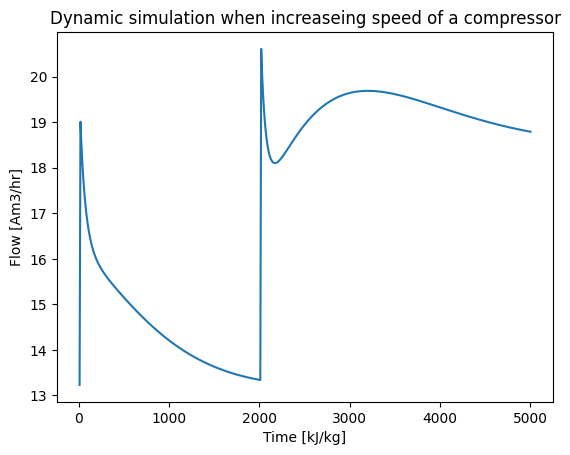

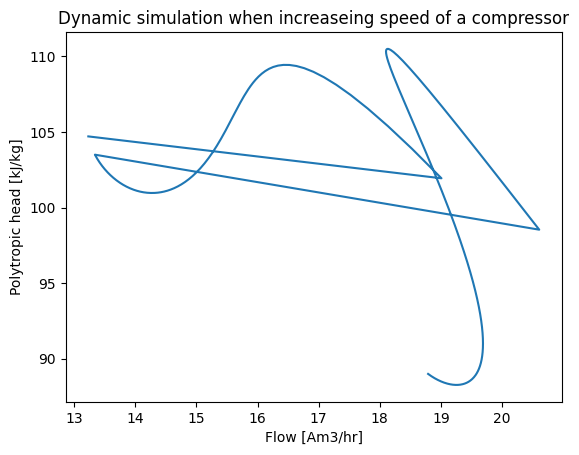

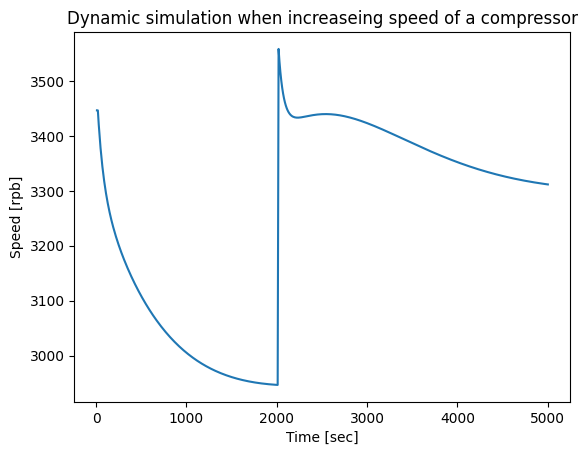

In [7]:
testSystem2 = jNeqSim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
testSystem2.addComponent("methane", 1.1);
testSystem2.addComponent("ethane", 0.1);
testSystem2.setMixingRule(2);

stream1 =  jNeqSim.processSimulation.processEquipment.stream.Stream("Stream1", testSystem2);
stream1.setFlowRate(501.0, "kg/hr");
stream1.setPressure(100.0, "bara");
stream1.setTemperature(55.0, "C");

valve1 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(50.0);
valve1.setPercentValveOpening(50);
valve1.setCalculateSteadyState(False);

separator1 = jNeqSim.processSimulation.processEquipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream());
separator1.setCalculateSteadyState(False);
separator1.setSeparatorLength(3.0);
separator1.setInternalDiameter(0.8);
separator1.setLiquidLevel(0.0);

compressor1 = jNeqSim.processSimulation.processEquipment.compressor.Compressor(separator1.getGasOutStream());
compressor1.setCalculateSteadyState(False);
compressor1.setOutletPressure(100.0);

separator2 = jNeqSim.processSimulation.processEquipment.separator.Separator("separator_2");
separator2.addStream(compressor1.getOutletStream());
separator2.setCalculateSteadyState(False);
separator2.setSeparatorLength(3.0);
separator2.setInternalDiameter(0.8);
separator2.setLiquidLevel(0.0);

valve2 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_2", separator2.getGasOutStream());
valve2.setOutletPressure(50.0);
valve2.setPercentValveOpening(50);
valve2.setCalculateSteadyState(False);

separatorPressureTransmitter = jNeqSim.processSimulation.measurementDevice.PressureTransmitter(separator2.getGasOutStream());

speedController = jNeqSim.processSimulation.controllerDevice.ControllerDeviceBaseClass();
speedController.setReverseActing(True);
speedController.setTransmitter(separatorPressureTransmitter);
speedController.setControllerSetPoint(100.0);
speedController.setControllerParameters(0.3, 500.0, 0.0);

p = jNeqSim.processSimulation.processSystem.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(separator1);
p.add(compressor1);
p.add(separator2);
p.add(separatorPressureTransmitter);
p.add(valve2);
compressor1.setController(speedController);



p.run();
compchartgenerator = jNeqSim.processSimulation.processEquipment.compressor.CompressorChartGenerator(compressor1);
compressor1.setCompressorChart(compchartgenerator.generateCompressorChart("normal"));
compressor1.getCompressorChart().setUseCompressorChart(True);
p.run();

print(" speed " , compressor1.getSpeed() , "feed flow "
, stream1.getFlowRate("kg/hr") , " compressor flow rate "
, compressor1.getInletStream().getFlowRate("kg/hr") , " out flow "
, valve2.getOutletStream().getFlowRate("kg/hr") , " delta p "
, (compressor1.getOutletStream().getPressure() - compressor1.getInletStream().getPressure())
, " pres inn " , compressor1.getInletStream().getPressure() , " pres out "
, compressor1.getOutletStream().getPressure());

p.setTimeStep(10.0);
p.runTransient();

time = []
pressuresep1 = []
pressuresep2= []
flow = []
head = []
speed = []

compressor1.setSpeed(compressor1.getSpeed() + 500);
for i in range(200):
  time.append(p.getTime())
  pressuresep1.append(separator1.getPressure())
  pressuresep2.append(separator2.getPressure())
  flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
  head.append(compressor1.getPolytropicFluidHead())
  speed.append(compressor1.getSpeed())
  p.runTransient();

speedController.setControllerSetPoint(120.0);

for i in range(300):
  time.append(p.getTime())
  pressuresep1.append(separator1.getPressure())
  pressuresep2.append(separator2.getPressure())
  flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
  head.append(compressor1.getPolytropicFluidHead())
  speed.append(compressor1.getSpeed())
  p.runTransient();

plt.plot(time, pressuresep1)
plt.plot(time, pressuresep2)
plt.title("Dynamic simulation when using a controller to vary speed of a compressor")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure in separator 1 and 2 [bara]")
plt.show()

plt.plot(time, flow)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.ylabel("Flow [Am3/hr]")
plt.xlabel("Time [kJ/kg]")
plt.show()

plt.plot(flow, head)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Polytropic head [kJ/kg]")
plt.show()

plt.plot(time, speed)
plt.title("Dynamic simulation when increaseing speed of a compressor")
plt.xlabel("Time [sec]")
plt.ylabel("Speed [rpb]")
plt.show()


#

#Example 3: Anti surge controll in dynamic compressor simulations
In this exampe we will add a surge line with an anti surge valve and add a anti surge controller to the compressor (PI regulator). We will observe how the anti surge valve opens after lowerin the inlet flow to the separator (closing the inlet valve).

 speed  3000.0 feed flow  500.0000000000001  compressor flow rate  505.0505000100001  out flow  499.9999950099002  delta p  54.93068548012232  pres inn  47.0  pres out  101.93068548012232  distancetosurge  0.2903346744704456  antisurgeflow  5.050505000100031  antisurgevalveopening  0.47307370180418773  compressorouttemperature  95.75345952511282


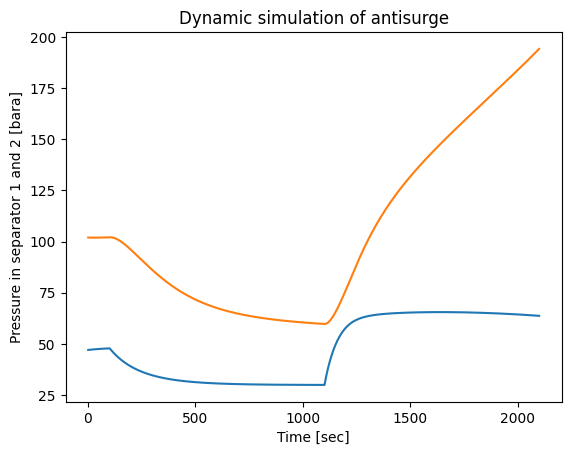

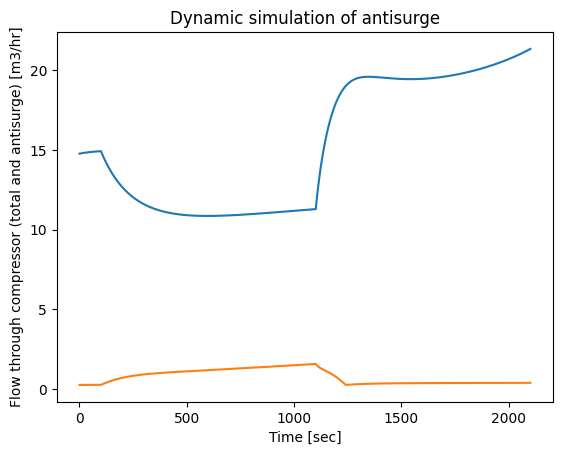

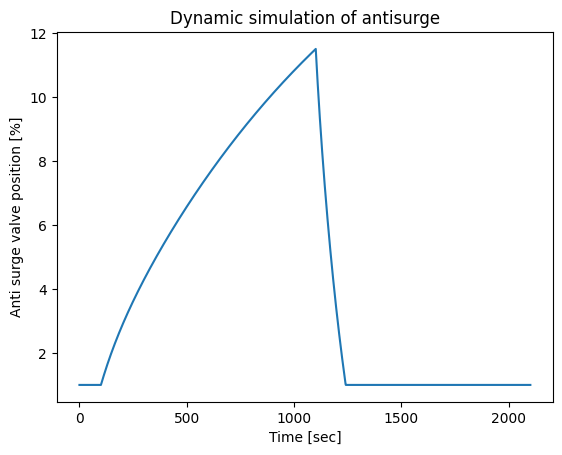

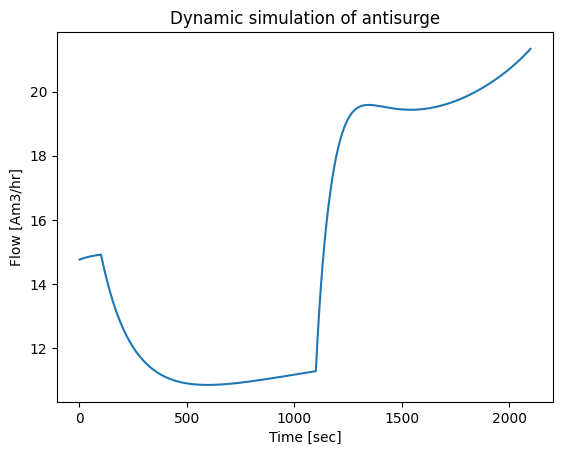

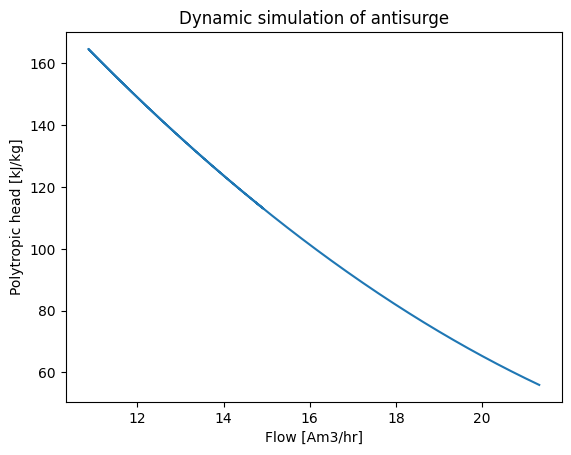

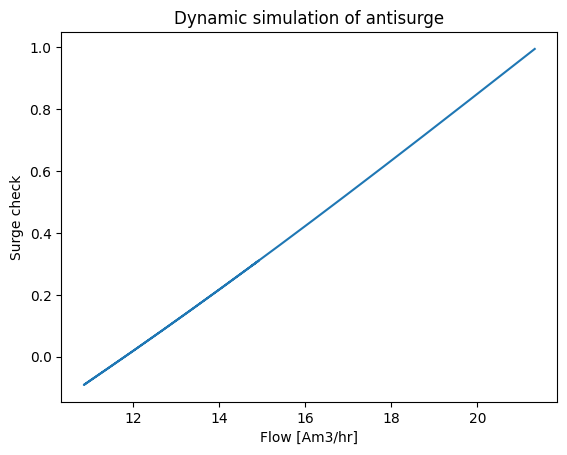

In [18]:
testSystem2 = jNeqSim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
testSystem2.addComponent("methane", 1.1);
testSystem2.addComponent("ethane", 0.1);
testSystem2.setMixingRule(2);

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream("Stream1", testSystem2);
stream1.setFlowRate(500.0, "kg/hr");
stream1.setPressure(100.0, "bara");
stream1.setTemperature(55.0, "C");

valve1 =  jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(50.0);
valve1.setPercentValveOpening(20);
valve1.setCalculateSteadyState(False);

resycstream = stream1.clone();
resycstream.setFlowRate(0.01, "kg/hr");

separator1 = jNeqSim.processSimulation.processEquipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream());
separator1.addStream(resycstream);
separator1.setCalculateSteadyState(False);
separator1.setSeparatorLength(3.0);
separator1.setInternalDiameter(0.8);
separator1.setLiquidLevel(0.0);

compressor1 = jNeqSim.processSimulation.processEquipment.compressor.Compressor(separator1.getGasOutStream());
compressor1.setCalculateSteadyState(False);
compressor1.setOutletPressure(100.0);

surgemonitor = jNeqSim.processSimulation.measurementDevice.CompressorMonitor(compressor1);
surgemonitor.setMaximumValue(5.0);
surgemonitor.setMinimumValue(-5.0);

aftercooler =  jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler("after cooler", compressor1.getOutletStream());
aftercooler.setOutTemperature(30.0, "C");
aftercooler.setCalculateSteadyState(False);

separator2 = jNeqSim.processSimulation.processEquipment.separator.Separator("separator_2");
separator2.addStream(aftercooler.getOutletStream());
separator2.setCalculateSteadyState(False);
separator2.setSeparatorLength(3.0);
separator2.setInternalDiameter(0.5);
separator2.setLiquidLevel(0.0);

gasfromsep2 = jNeqSim.processSimulation.processEquipment.stream.Stream("gas from sep", separator2.getGasOutStream());

splitter =  jNeqSim.processSimulation.processEquipment.splitter.Splitter("splitter1", gasfromsep2);
splitter.setSplitFactors([0.99, 0.01]);
splitter.setCalculateSteadyState(False);

recycleValve = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("anti surge valve", splitter.getSplitStream(1));
recycleValve.setPressure(47.0);
recycleValve.setCalculateSteadyState(False);
recycleValve.setMinimumValveOpening(1.0);
recycleValve.setPercentValveOpening(2);

pressureset = jNeqSim.processSimulation.processEquipment.util.SetPoint("HP pump set", recycleValve, "pressure", separator1.getGasOutStream());

recycle =  jNeqSim.processSimulation.processEquipment.util.Recycle("resycle 1");
recycle.addStream(recycleValve.getOutletStream());
recycle.setOutletStream(resycstream);
recycle.setFlowAccuracy(1e-4);

valve2 = jNeqSim.processSimulation.processEquipment.valve.ThrottlingValve("valve_2", splitter.getSplitStream(0));
valve2.setOutletPressure(50.0);
valve2.setPercentValveOpening(50);
valve2.setCalculateSteadyState(False);
valve2.setMinimumValveOpening(1.0);

surgeController = jNeqSim.processSimulation.controllerDevice.ControllerDeviceBaseClass();
surgeController.setReverseActing(True);
surgeController.setTransmitter(surgemonitor);
surgeController.setControllerSetPoint(0.1);
surgeController.setControllerParameters(1.0, 200.0, 0.0);
surgeController.setActive(True);

p = jNeqSim.processSimulation.processSystem.ProcessSystem()
p.add(stream1);
p.add(resycstream);
p.add(valve1);
p.add(separator1);
p.add(compressor1);
p.add(surgemonitor);
p.add(aftercooler);
p.add(separator2);
p.add(gasfromsep2);
p.add(splitter);
p.add(recycleValve);
p.add(recycle);
p.add(valve2);
recycleValve.setController(surgeController);

#Setting compressor curves
p.run();
recycleValve.setCv(valve2.getCv());
compchartgenerator = jNeqSim.processSimulation.processEquipment.compressor.CompressorChartGenerator(compressor1);
compressor1.setCompressorChart(compchartgenerator.generateCompressorChart("normal"));
compressor1.getCompressorChart().setUseCompressorChart(True);
p.run();

print(" speed " , compressor1.getSpeed() , "feed flow "
, stream1.getFlowRate("kg/hr") , " compressor flow rate "
, compressor1.getInletStream().getFlowRate("kg/hr") , " out flow "
, valve2.getOutletStream().getFlowRate("kg/hr") , " delta p "
, (compressor1.getOutletStream().getPressure() - compressor1.getInletStream().getPressure())
, " pres inn " , compressor1.getInletStream().getPressure() , " pres out "
, compressor1.getOutletStream().getPressure() , " distancetosurge "
, surgemonitor.getMeasuredValue("distance to surge") , " antisurgeflow "
, recycleValve.getOutletStream().getFlowRate("kg/hr") , " antisurgevalveopening "
, recycleValve.getPercentValveOpening() , " compressorouttemperature "
, compressor1.getOutStream().getTemperature("C"));

p.setTimeStep(1.0);

time = []
pressuresep1 = []
pressuresep2= []
flow = []
antisrugevalveposition = []
antisrugeflow = []
head = []
distancetosurge = []

p.runTransient();
for i in range(100):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    p.runTransient();

#setting inlet valve to 5% opening
valve1.setPercentValveOpening(5.0);

for i in range(1000):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    p.runTransient();

valve1.setPercentValveOpening(50.0);

for i in range(1000):
    time.append(p.getTime())
    pressuresep1.append(separator1.getPressure())
    pressuresep2.append(separator2.getPressure())
    flow.append(compressor1.getInletStream().getFlowRate("m3/hr"))
    antisrugevalveposition.append(recycleValve.getPercentValveOpening())
    antisrugeflow.append(recycleValve.getOutletStream().getFlowRate("m3/hr"))
    head.append(compressor1.getPolytropicFluidHead())
    distancetosurge.append(surgemonitor.getMeasuredValue("distance to surge"))
    p.runTransient();

plt.plot(time, pressuresep1)
plt.plot(time, pressuresep2)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure in separator 1 and 2 [bara]")
plt.show()

plt.plot(time, flow)
plt.plot(time, antisrugeflow)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Flow through compressor (total and antisurge) [m3/hr]")
plt.show()

plt.plot(time, antisrugevalveposition)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Time [sec]")
plt.ylabel("Anti surge valve position [%]")
plt.show()

plt.plot(time, flow)
plt.title("Dynamic simulation of antisurge")
plt.ylabel("Flow [Am3/hr]")
plt.xlabel("Time [sec]")
plt.show()

plt.plot(flow, head)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Polytropic head [kJ/kg]")
plt.show()

plt.plot(flow, distancetosurge)
plt.title("Dynamic simulation of antisurge")
plt.xlabel("Flow [Am3/hr]")
plt.ylabel("Surge check")
plt.show()

Text(0, 0.5, 'Head [kJ/kg]')

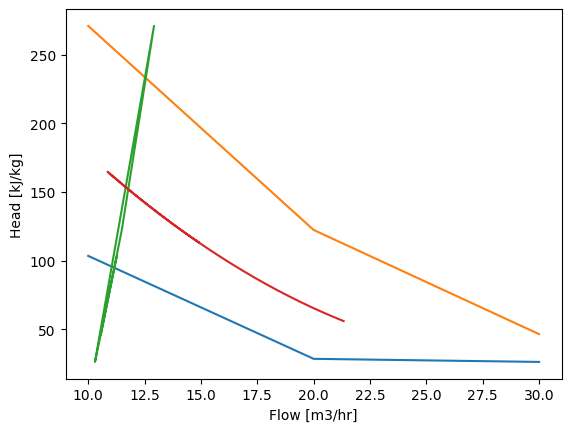

In [19]:
import numpy as np
flow1 = []
head1 = []
head2 = []
surge =[]

for i in range(10,40,10):
    flow1.append(i)
    head1.append(compressor1.getCompressorChart().getPolytropicHead(i, 2500))
    head2.append(compressor1.getCompressorChart().getPolytropicHead(i, 3500))

flowsurgee = np.array((head1+head2)).sort()#.tolist()
for i in (head1+head2):
  surge.append(compressor1.getCompressorChart().getSurgeCurve().getSurgeFlow(i))

plt.plot(flow1, head1)
plt.plot(flow1, head2)
plt.plot(surge, (head1+head2))
plt.plot(flow, head)
plt.xlabel('Flow [m3/hr]')
plt.ylabel('Head [kJ/kg]')